### Explore meteorological data

In [1]:
import os
import zipfile
import pandas as pd
import glob
import keplergl
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import re
import numpy as np
from pyproj import Proj

In [2]:
# Drive folder with original data: https://drive.google.com/drive/folders/1me2IpDY3om6IRKv_WMT5W6Qw0r9DI74C

In [2]:
os.listdir('data')

['.DS_Store',
 '07-HGPT-MT-07.- Estacion Aeropuerto-20210505T205931Z-001.zip',
 'Estaciones_meteorologicas.csv',
 '02-HGPT-MT-06.- Estacion Baños-20210426T162523Z-001.zip',
 'Inventario Estaciones Meteo.xls',
 '02-HGPT-MT-06.- Estacion Baños']

In [4]:
### Read a sheet from an excel file
file = glob.glob('data/*.xls')[0]
sheets = pd.read_excel(file, None)
list(sheets.keys())
df = pd.read_excel(io=file, sheet_name=list(sheets.keys())[0], engine ='xlrd',skiprows = 1)

In [5]:
df = pd.read_csv('data/Estaciones_meteorologicas.csv')
df.head()

,fuente,numero,codigo,nombre,tipo,provincia,estado,fecha_instalacion,latitud,longitud,parametros_medicion
0,esta_inamhi,1,M0029,BAÑOS,CP,TUNGURAHUA,FUNCIONANDO,20-jun-62,12329.0,782505.0,"Temperatura Max, temperatura Min, Temperatura,..."
1,esta_inamhi,2,M0258,QUEROCHACA(UTA),CP,TUNGURAHUA,FUNCIONANDO,2-nov-85,12202.0,783620.0,"Temperatura Max, temperatura Min, Temperatura,..."
2,esta_inamhi,3,M1069,CALAMACA CONVENIO INAMHI HCPT,CP,TUNGURAHUA,FUNCIONANDO,4-jul-88,11634.0,784908.0,"Temperatura Max, temperatura Min, Temperatura,..."
3,esta_inamhi,4,M0126,PATATE,CO,TUNGURAHUA,FUNCIONANDO,1-may-63,11801.0,783000.0,"Temperatura Max, temperatura Min, Temperatura,..."
4,esta_inamhi,5,M0127,PILLARO,CO,TUNGURAHUA,FUNCIONANDO,1-Dec-63,11010.0,783310.0,"Temperatura Max, temperatura Min, Temperatura,..."


In [17]:
myProj = Proj("+proj=utm +zone=17S, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [18]:
lon, lat = myProj(df['longitud'].values, df['latitud'].values, inverse=True)

In [21]:
lon

array([-78.46203009, -78.45201988, -78.44045693, -78.45758644,
       -78.45480388, -78.45171471, -78.44541252, -78.44897653,
       -78.4688712 , -78.45633813, -78.45262241, -19.42934026,
       -17.22465419, -15.76969217, -15.76969217, -19.05039204,
       -18.61256189, -17.10057497, -20.11372178, -20.81104732,
       -19.31796305, -18.50098482, -21.81322966, -15.55097746,
       -12.87258391, -18.23847411,          inf, -20.90950484,
       -17.96268711, -19.90939236, -19.42934026, -17.22465419,
       -15.76969217, -15.76969217, -19.05039204, -18.61256189,
       -17.10057497, -20.11372178, -20.81104732, -19.31796305,
       -18.50098482, -21.81322966, -15.55097746, -12.87258391,
       -18.23847411,          inf, -20.90950484, -17.96268711,
       -19.90939236])

In [ ]:
### There is a problem with the coordinates. I can extract the coordinates from ESTA_INAMHI but not form the other 2. UTM format

In [39]:
df_inamhi = df[df['fuente']== 'esta_inamhi']
df_inamhi.latitud = -df_inamhi.latitud/1e4
df_inamhi.longitud = -df_inamhi.longitud/1e4

In [40]:
gdf = gpd.GeoDataFrame(
    df_inamhi, geometry=gpd.points_from_xy(df_inamhi.longitud, df_inamhi.latitud))

In [53]:
gdf = gdf.set_crs(epsg=4326)

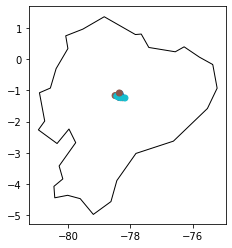

In [56]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
SA = world.query('name == "Ecuador"')
gdf4326 = gdf.to_crs(world.crs)

fig, ax = plt.subplots()
ax.set_aspect('equal')
SA.plot(ax=ax, color='white', edgecolor='black')
gdf4326.plot(ax=ax, column='tipo',figsize=(20,20))

plt.show()

#### Automate data extraction from Drive downloads

In [3]:
path = '/Users/tamarahuete/Documents/Github_repos/TFM21/data'
#ziplist = glob.glob(f'{path}/*.zip')
ziplist = glob.glob('data/*.zip')

In [4]:
zip = zipfile.ZipFile(f'{ziplist[0]}')
zip.namelist()[0:5]

['07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/Aeropuerto_5min_20130624.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2018-01-11/8310_5min_20180116.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/8310_1min_20170404.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2015-07-02/8310_5min_20150714_subir.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2018-01-11/8310_5min_20180116_subir.csv']

In [5]:
#order ziplist by date
a = []
for i in range(len(zip.namelist())):
    date_str = zip.namelist()[i].split('/')[1]
    try:
        date_date = datetime.strptime(date_str, '%Y-%m-%d')
    except:
        print(f'{date_str} is not a date')
    a.append(date_date)

Aeropuerto_1hora_Todo.xls is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date
00_RESUMEN_1MIN_07 is not a date


In [6]:
# get unique values
unique_dates = list(set(a))
# order by date
unique_dates.sort()
unique_dates
#convert back to string
str_dates = []
for l in range(len(unique_dates)):
    str_dates.append(unique_dates[l].strftime('%Y-%m-%d'))
str_dates

['2013-03-26',
 '2013-05-07',
 '2013-06-13',
 '2013-08-01',
 '2013-08-28',
 '2013-10-01',
 '2014-01-10',
 '2014-04-09',
 '2014-07-23',
 '2014-11-24',
 '2015-02-05',
 '2015-04-27',
 '2015-07-02',
 '2015-10-28',
 '2016-01-11',
 '2016-04-12',
 '2016-08-25',
 '2017-01-12',
 '2017-04-09',
 '2017-10-01',
 '2017-10-10',
 '2017-10-30',
 '2018-01-11',
 '2018-06-13',
 '2018-09-20',
 '2018-12-21',
 '2019-04-05',
 '2019-06-27',
 '2019-09-27',
 '2020-01-09']

In [7]:
## Reorder files
files_by_date = []
for dates in str_dates:
    #r = re.compile(f'.*/{dates}/.*') # all files (including excel sheets)
    r = re.compile(f'.*/{dates}/.*.csv') # only csv files
    newlist = list(filter(r.match, zip.namelist())) 
    files_by_date.extend(newlist)

In [8]:
files_by_date

['07-HGPT-MT-07.- Estacion Aeropuerto/2013-03-26/8310_1min_20170404.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-03-26/Aeropuerto_1hora_20130517.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-05-07/8310_1min_20170404.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-05-07/Aeropuerto_5min_20140417.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/Aeropuerto_5min_20130624.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/8310_1min_20170404.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-08-01/8310_1min_20170405.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-08-01/Aeropuerto_5min_20130808.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-08-28/Aeropuerto_5min_20130828.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-08-28/8310_1min_20170405.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-10-01/8310_1min_20170405.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-10-01/Aeropuerto_5min_20131008.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2014-01-10/Aeropuerto_5min_20140114.c

In [9]:
def read_meteo_csv(zf, file): 
    try:
        df = pd.read_csv(zf.open(file),header=None, encoding = 'latin-1')
        print('Success regular csv, no header, latin encoding')
    except:
        try:
            df = pd.read_csv(zf.open(file), sep = ';', encoding = 'latin-1')
            if len(df.columns) == 1:
                df = df[df.columns[0]].str.split(',',expand=True)
                df = df.iloc[1:]
            print('Success sep ";", latin encoding')
        except:
            print('Failed')
    
    ## Detect and elminate empty columns- incluiding columns with low number of values (<1% of file)
    df = df.replace('', np.nan)
    empty_cols = [col for col in df.columns if df[col].isnull().all() or round(df[col].isnull().value_counts()[0]/len(df[col]),2) < 0.01]
    df.drop(empty_cols,
        axis=1,
        inplace=True)
    if len(df.columns)==5:
        df.columns = ['Date', 'Time','Variable', 'Value','type']
    print(f'file ={i}, cols = {len(df.columns)}')
    return df

In [ ]:
### Convert to long format
#df.melt(id_vars='Fecha', value_vars=list(df.columns)[1:], var_name='Variable', value_name='value')

In [12]:
zf = zipfile.ZipFile(f'{ziplist[0]}')
summary_df = pd.DataFrame(columns = ['station','filename','colnum','colnames','nrows'])
df = read_meteo_csv(zf,files_by_date[1])

Success sep ";", latin encoding
file =137, cols = 5


In [ ]:
### Get unique variable names

zf = zipfile.ZipFile(f'{ziplist[0]}')
summary_df = pd.DataFrame(columns = ['station','filename','colnum','colnames','nrows'])
for i in range(0,len(files_by_date)):
    
    df = read_meteo_csv(zf,files_by_date[i])
    if len(df.columns)==5:
        colname = [list(df.Variable.unique())]
    else:
        colname= [list(df.columns)]
    try:
        filename=zip.namelist()[i].split('/')[2]
    except:
        filename=zip.namelist()[i].split('/')[1]
    fill = {'station':zip.namelist()[i].split('/')[0].split(' ')[2],
            'filename':filename,
            'colnum':len(df.columns),
            'colnames':colname,
            'nrows':len(df)}
    summary_df = summary_df.append(fill, ignore_index=True)

In [61]:
summary_df.to_csv('summary_aeropuerto.csv')

In [58]:
all_var = []
for i in range(0,len(summary_df)):
    file_vars= summary_df.colnames[i][0]
    not_in_list =list(set(file_vars) - set(all_var))
    all_var.extend(not_in_list)                              

In [109]:
df = read_meteo_csv(zf,files_by_date[1])
df.head(14)

Success sep ";", latin encoding
file =76, cols = 5


,Date,Time,Variable,Value,type
1,02/08/2013,11:00:00,BAT,12.64,G
2,02/08/2013,11:00:00,TB1hrAcc,0.10,G
3,02/08/2013,11:00:00,RelHumidAvg,48.34,B
4,02/08/2013,11:00:00,RelHumidMin,45.91,G
5,02/08/2013,11:00:00,RelHumidMax,50.31,G
6,02/08/2013,11:00:00,AT1HrAvg,21.19,B
7,02/08/2013,11:00:00,AT1HrMin,21.04,G
8,02/08/2013,11:00:00,AT1HrMax,21.34,G
9,02/08/2013,11:00:00,WindMnSpdSclr,1.59,G
10,02/08/2013,11:00:00,WindMnDirUnit,163.36,G


In [74]:
all_var = sorted([str(i) for i in all_var])

['AT1HrAvg',
 'AT1HrMax',
 'AT1HrMin',
 'AT5minAvg',
 'AT5minMax',
 'AT5minMin',
 'ATAvg',
 'BAT',
 'Direccion',
 'Fecha',
 'H_Max',
 'H_Min',
 'Humedad',
 'None',
 'Precipitacion',
 'RH5minAvg',
 'RH5minMax',
 'RH5minMin',
 'RHAvg',
 'RelHumidAvg',
 'RelHumidMax',
 'RelHumidMin',
 'TB1hrAcc',
 'TB1minAcc',
 'TB5minAcc',
 'T_Max',
 'T_Min',
 'Temperatura',
 'Velocidad',
 'WD5minAvg',
 'WD5minMax',
 'WD5minMin',
 'WDAvg',
 'WS5minAvg',
 'WS5minMax',
 'WS5minMin',
 'WSAvg',
 'WindMaxDir',
 'WindMaxSpdSclr',
 'WindMinSpdSclr',
 'WindMnDirUnit',
 'WindMnSpdSclr',
 'nan']

In [116]:
## Temperature:

#'Fecha', not clear about 'TB1hrAcc','TB1minAcc','TB5minAcc','BAT'

replace_values ={'ATAvg' :['AT1HrAvg', 'AT5minAvg', 'ATAvg','Temperatura'],
 'ATMin' : ['AT1HrMin', 'AT5minMin','T_Min'],
 'ATMax' : ['AT1HrMax','AT5minMax', 'T_Max'],
 
 # Relative Humidity
 'RHAvg' : ['Humedad','RH5minAvg','RHAvg','RelHumidAvg'],
 'RHMin' : ['H_Min','RH5minMax','RelHumidMax'],
 'RHMax' : ['H_Max', 'RH5minMin', 'RelHumidMin'],

 # Wind Speed
 'WSAvg' : ['Velocidad','WS5minAvg','WSAvg','WindMnSpdSclr'],
 'WSMin' : ['WindMinSpdSclr','WS5minMin'],
 'WSMax' : ['WindMaxSpdSclr','WS5minMax'],

 # Wind Direction
 'WDAvg' : ['Direccion', 'WDAvg','WD5minAvg','WindMnDirUnit'],
 'WDMin' : ['WD5minMin'],
 'WDMax' : ['WD5minMax','WindMaxDir'],

 # Rain
 'PAvg' : ['Precipitacion']}

In [132]:
## repalce variables
for variable in list(replace_values.keys()):
    df =df.replace(to_replace =replace_values[variable], value = variable)


In [133]:
df

,Date,Time,Variable,Value,type
1,02/08/2013,11:00:00,BAT,12.64,G
2,02/08/2013,11:00:00,TB1hrAcc,0.10,G
3,02/08/2013,11:00:00,RHAvg,48.34,B
4,02/08/2013,11:00:00,RHMax,45.91,G
5,02/08/2013,11:00:00,RHMin,50.31,G
...,...,...,...,...,...
14362,03/26/2013,11:00:00,WDAvg,233.30,G
14363,03/26/2013,11:00:00,WSMin,0.00,G
14364,03/26/2013,11:00:00,WSMax,2.98,G
14365,03/26/2013,11:00:00,WDMax,200.03,G


In [128]:
### next step: create new df that has all the column names and extend each df into that format, 
### adding date, time, 5 min , 1 min, 1 h...

NameError: name 'value' is not defined